<a href="https://colab.research.google.com/github/jjpeh/W207/blob/master/W207_Home_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Home Price Prediction

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# dataset from Kaggle: kaggle competitions download -c house-prices-advanced-regression-techniques

## Import Dataset from Kaggle

In [8]:
#!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
# copy the API key to the kaggle directory
!cp kaggle.json ~/.kaggle/
# list all kaggle api dataset
#!kaggle datasets list
# download dataset from kaggle for the first time
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

Saving kaggle.json to kaggle (2).json
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.0MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 58.9MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 60.1MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.6MB/s]
 data_description.txt  'kaggle (2).json'   sample_data		   test.csv
'kaggle (1).json'       kaggle.json	   sample_submission.csv   train.csv


In [9]:
# read train and test dataset into dataframe
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
train_df.head(10)
#test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## EXPLORATORY DATA ANALYSIS (EDA)

### Initial Features Study

In [10]:
# look at all features available
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Numeric Data

In [11]:
# summary of features with numeric values
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- Lot frontage (linear feet of street connected to property) has lesser count
- lot area has big variation
- sales prices have some outliers
- MSSubClass should be categorical variable instead of numeric


Text(0.5, 1.0, 'Histogram of Lot Area')

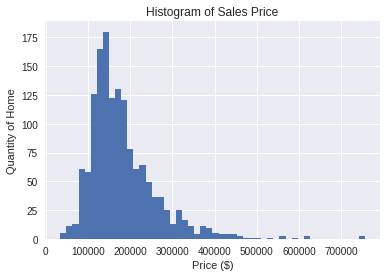

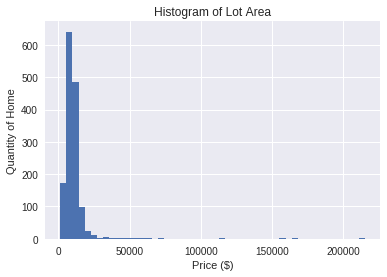

In [12]:
# some initial plots on important variables
plt.figure(1)
plt.hist("SalePrice", bins=50, data=train_df)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of Sales Price")

plt.figure(2)
plt.hist("LotArea", bins=50, data=train_df)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of Lot Area")

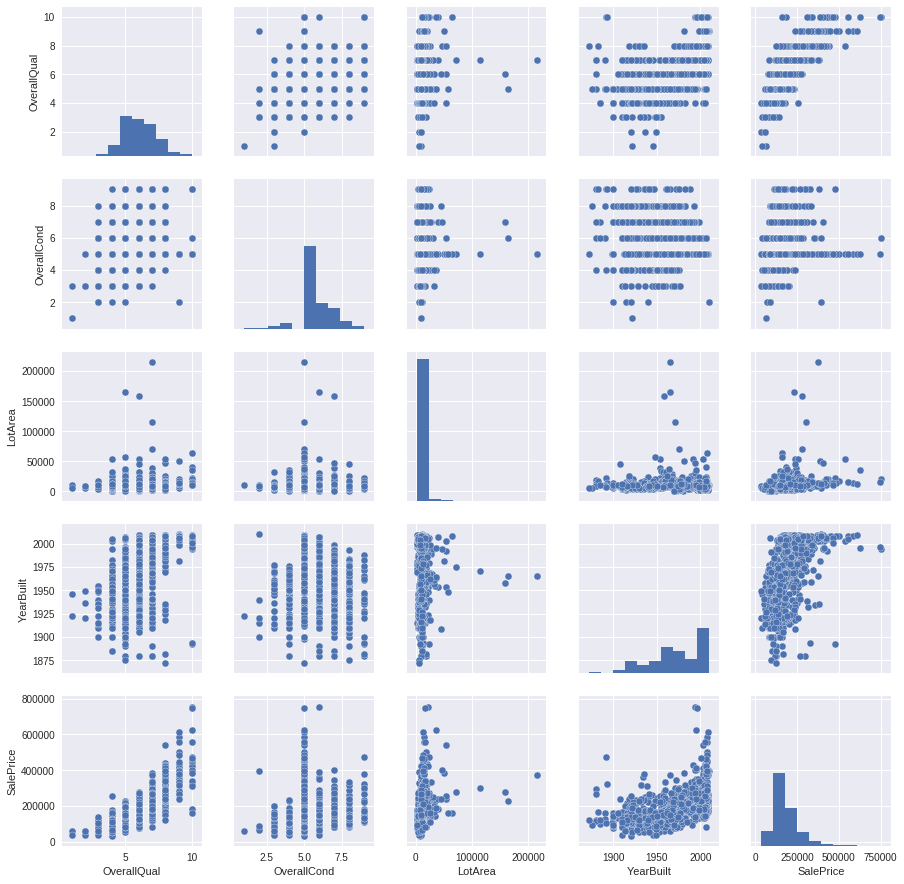

In [13]:
# Look at scatter plot matrix for important variables
sns.set()
scatter1 = ["OverallQual", "OverallCond", "LotArea", "YearBuilt", "SalePrice"]
sns.pairplot(train_df[scatter1], size = 2.5)

Above are some of the features that could potentially affect the price of home sales price.
- Overall condition and year of build is linearly correlated to sales price.
- Most of the old houses (year of built) are priced on the lower range.
- Not much correlation between lot area with sales price



In [0]:
# save important numeric features here
good_features_numeric = ['OverallCond', 'YearBuilt']

### Categorical Data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


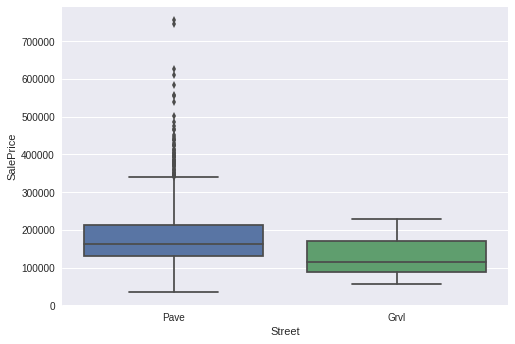

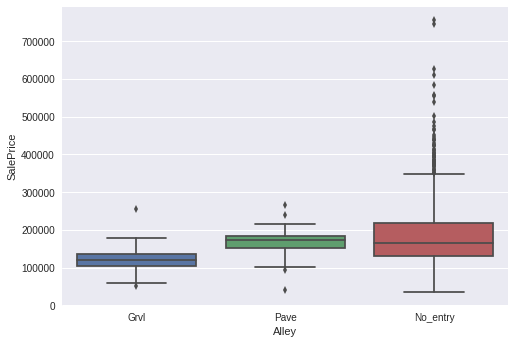

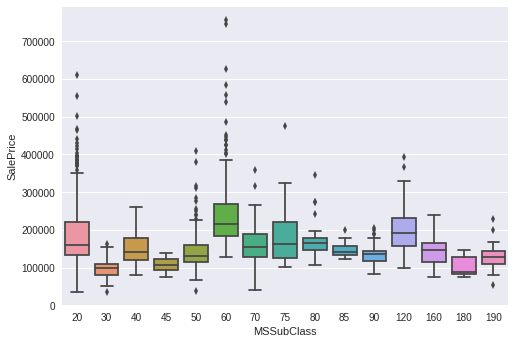

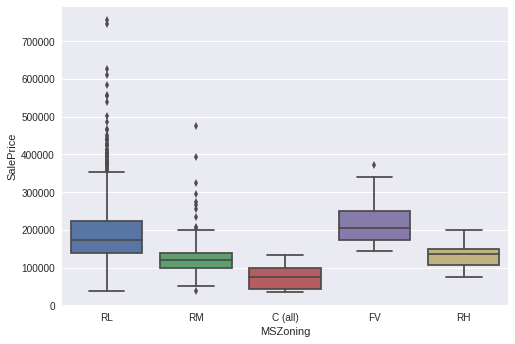

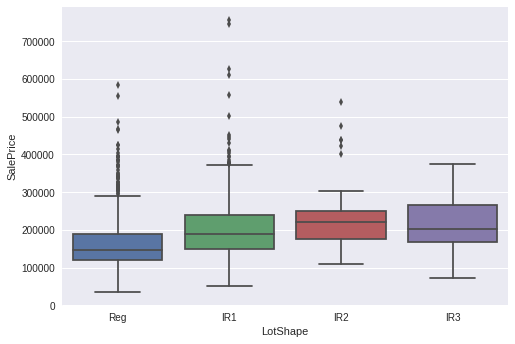

In [44]:
# Plot variables in box plot to look at categorical data
#plt.figure(1)
#sns.boxplot(x='Street', y='SalePrice', data=train_df)
#sns.swarmplot(x='Street', y='SalePrice', data=train_df,color=".25")

# plot alley, need to fill up NA as a new category
#to_cat = ['MSSubClass', 'MSZoning', 'LotShape']
train_df['Alley'] = train_df['Alley'].astype('category')
if train_df['Alley'].isnull().any():
  train_df['Alley'] = train_df['Alley'].cat.add_categories(['No_entry'])
  train_df['Alley'] = train_df['Alley'].fillna('No_entry')
  
box_features = ['Street', 'Alley', 'MSSubClass', 'MSZoning', 'LotShape']
for i in box_features:
  plt.figure(i)
  sns.boxplot(x=i, y='SalePrice', data=train_df)


### Transformation

### Check for Correlation and Covariance

In [47]:
corr1 = train_df[good_features_numeric + ['SalePrice']].corr
sns.heatmap(corr1)

ValueError: ignored

## FEATURE ENGINEERING

## MODELING

## CONCLUSION

### Discussion on some improvements to be done and omitted variables to be considered

## REFERENCE & ADDITIONAL RESOURCES